# ETF Pipeline

> ETF flow decompositions pipeline.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# | default_exp etf_pipeline

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | export
import os

import click
from arcticdb import Arctic, QueryBuilder
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
from pathlib import Path
from lobster_tools.config import MainConfig, register_configs
from lobster_tools.preprocessing import *
from lobster_tools.querying import *
from lobster_tools.flow_decomposition import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from itertools import product
import datetime
from dataclasses import dataclass
from functools import partial
import json
from typing import Literal
import numpy as np
from pprint import pprint

In [ ]:
# | export

def set_hydra_overrides(execution_environment: Literal["local", "server"]):
    match execution_environment:
        case "local":
            overrides = ["hyperparameters=simple", "universe=simple", "data_config=local"]
        case "server":
            # overrides = ["hyperparameters=full", "universe=XLE", "data_config=server"]
            overrides = ["hyperparameters=full"]
        case _:
            raise ValueError("execution_environment must be either 'local' or 'server'")
    return overrides

os.environ["ETF_RUN_MODE"] = "server"
execution_environment = os.environ.get("ETF_RUN_MODE")
overrides = set_hydra_overrides(execution_environment)
print(overrides)
overrides = ["hyperparameters=simple", "universe=simple", "data_config=local"]

register_configs()
with initialize(version_base=None, config_path=None):
    
    # defaults = [{"hyperparameters": "simple"}, "_self_", {"override hydra/launcher": "joblib"}]
    overrides = ["data_config.csv_files_path=baz"]
    overrides = ["data_config=server"]
    cfg_omega = compose(config_name="config", overrides=overrides)
    print(cfg_omega)
    cfg: MainConfig = OmegaConf.to_object(compose(config_name="config", overrides=overrides))
    print(cfg)

directory_path = cfg.data_config.csv_files_path
etfs = cfg.universe.etfs
equities = cfg.universe.equities
# fix this
date_range = tuple(cfg.data_config.date_range)
markouts = cfg.hyperparameters.markouts
finest_resample = cfg.hyperparameters.finest_resample
max_markout = cfg.hyperparameters.max_markout

load: Literal["both", "messages", "book"] = "both"
clip_trading_hours = True
add_ticker_column = True

ticker = "APA"
date_range = ("2020-01-02", "2020-01-04")
date_range = "2020-01-02"

['hyperparameters=full']
{'hyperparameters': {'tolerances': ['150us', '500us'], 'resample_freq': '5min', 'markouts': ['30S', '5min']}, 'universe': {'etfs': ['SPY'], 'equities': ['AIG', 'GE']}, 'data_config': {'date_range': ['2020-01-02', '2020-01-02'], 'csv_files_path': '/nfs/home/nicolasp/home/data/tmp', 'zip_files_path': '/nfs/lobster_data/lobster_raw'}, 'db': {'db_path': '/nfs/home/nicolasp/home/data/arctic', 'library_name': 'lobster', 'columns_per_segment': 63}, 'sample_data': {'ticker': 'AMZN', 'levels': 5}}
MainConfig(defaults=[{'hyperparameters': 'simple'}, {'universe': 'simple'}, {'data_config': 'local'}, '_self_'], db=ArcticDBConfig(db_path='/nfs/home/nicolasp/home/data/arctic', library_name='lobster', columns_per_segment=63), data_config=DataConfig(date_range=['2020-01-02', '2020-01-02'], csv_files_path='/nfs/home/nicolasp/home/data/tmp'), hyperparameters=HyperparametersConfig(tolerances=['150us', '500us'], resample_freq='5min', markouts=['30S', '5min']), universe=UniverseCon

In [ ]:
# with initialize_config_module(version_base=None, config_module="lobster_tools.config"):
#     cfg = compose(overrides=["data_config=server"])
#     print(cfg)

In [ ]:
# Data = partial(Data, 
#                     ticker="GE", 
#                     date_range=date_range,
#                     directory_path=directory_path,
#                     load=load,
#                 )

### Single day

In [ ]:
# | eval: false
Data(directory_path=directory_path, ticker="APA", date_range="2020-01-02")

In [ ]:
# | eval: false
equity_data = Data(directory_path=directory_path,
                   ticker=ticker,
                   date_range=date_range,
                   load=load,
                   clip_trading_hours=clip_trading_hours,
                   add_ticker_column=add_ticker_column)

equity_lobsters = Lobster(equity_data)

### Multi-day

In [ ]:
# | eval: false
equity_data = [
    Data(
        directory_path=directory_path,
        ticker=ticker,
        date_range=date_range,
        load=load,
        clip_trading_hours=clip_trading_hours,
        add_ticker_column=add_ticker_column,
    )
    for ticker in equities
]

equity_lobsters = [Lobster(data) for data in equity_data]

equity_executions = pd.concat(
    [lobster.messages.pipe(get_executions) for lobster in equity_lobsters]
)
equity_executions.sort_index(inplace=True)

In [ ]:
# | eval: false
etf_data = [
    Data(
        directory_path=directory_path,
        ticker=ticker,
        date_range=date_range,
        load=load,
        clip_trading_hours=clip_trading_hours,
        add_ticker_column=add_ticker_column,
    )
    for ticker in etfs
]

etf_lobsters = [Lobster(data) for data in etf_data]

etf_executions = pd.concat(
    [lobster.messages.pipe(get_executions) for lobster in etf_lobsters]
)
etf_executions.sort_index(inplace=True)

### Load with ArcticDB

In [ ]:
# | eval: false
db_path = cfg.db.db_path

conn = f'lmdb://{db_path}'
arctic = Arctic(conn)

library = arctic['lobster']
print('available tickers:')
print(library.list_symbols())

available tickers:
['APA', 'XOM', 'EOG', 'OXY', 'MPC', 'HES', 'BKR', 'KMI', 'PXD', 'PSX', 'XLE', 'HAL', 'DVN', 'OKE', 'CVX', 'FANG', 'VLO', 'WMB', 'COP', 'SLB']


In [ ]:
# | eval: false
def get_data_from_arctic(ticker, date):
    q = QueryBuilder()
    q = q.date_range((pd.Timestamp(f"{date}T09:29"), pd.Timestamp(f"{date}T16:01")))
    # get executions
    q = q[q.event.isin(EventGroup.EXECUTIONS.value)]
    df = library.read(ticker, query_builder=q, columns=["event", "order_id", "size", "price", "direction", "bid_price_1", "ask_price_1"]).data
    
    # do assign here for now
    df = df.assign(ticker=ticker)
    return df

In [ ]:
# | eval: false
def get_data_from_arctic_(ticker):
    q = QueryBuilder()
    q = q.date_range((pd.Timestamp(f"2020-01-02T09:29"), pd.Timestamp(f"2020-01-03T16:01")))
    # get executions
    q = q[q.event.isin(EventGroup.EXECUTIONS.value)]
    df = library.read(ticker, query_builder=q, columns=["event", "order_id", "size", "price", "direction", "bid_price_1", "ask_price_1"]).data
    
    # do assign here for now
    df = df.assign(ticker=ticker)
    return df

In [ ]:
# | eval: false
# equities=["APA", "BKR", "HAL"]
# all csv in folder
# equities=['APA', 'XOM', 'EOG', 'OXY', 'MPC', 'HES', 'BKR', 'KMI', 'PXD', 'PSX', 'HAL', 'DVN', 'OKE', 'CVX', 'FANG', 'VLO', 'WMB', 'COP', 'SLB']
equities = ['HES',
 'EOG',
 'VLO',
 'DVN',
 'OXY',
 'PXD',
 'XOM',
 'COP',
 'WMB',
 'HAL',
 'PSX',
 'CVX',
 'OKE',
 'BKR']
etfs = ["XLE"]

In [ ]:
# | eval: false
equity_executions = pd.concat(
    [get_data_from_arctic_(ticker=ticker) for ticker in equities]
).sort_index()

In [ ]:
# | eval: false
equity_executions

,event,order_id,size,price,direction,ask_price_1,bid_price_1,ticker
datetime,,,,,,,,
2020-01-02 09:30:00.207048226,6,4294967295,0,0.00,-1,112.28,110.94,PSX
2020-01-02 09:30:00.231936724,6,4294967295,0,0.00,-1,26.34,26.04,DVN
2020-01-02 09:30:00.261987791,6,4294967295,0,0.00,-1,121.30,120.50,CVX
2020-01-02 09:30:00.341665721,6,4294967295,0,0.00,-1,41.70,41.60,OXY
2020-01-02 09:30:00.483424790,6,4294967295,0,0.00,-1,152.40,150.86,PXD
...,...,...,...,...,...,...,...,...
2020-01-03 15:59:59.930380639,4,306687397,200,65.71,1,65.75,65.71,COP
2020-01-03 15:59:59.930380639,4,306687421,100,65.71,1,65.75,65.69,COP
2020-01-03 15:59:59.951695932,4,342373083,100,76.57,-1,76.59,76.56,OKE


In [ ]:
# | eval: false
etf_executions = pd.concat(
    [get_data_from_arctic(ticker=ticker, date="2020-01-02") for ticker in etfs]
).sort_index()

In [ ]:
# | eval: false
etf_executions = pd.concat(
    [get_data_from_arctic_(ticker=ticker) for ticker in etfs]
).sort_index()

In [ ]:
#TODO: pickle and load pickles.. looks like nbdev doesn't work with cell magics

In [ ]:
# | eval: false
%store etf_executions
%store equity_executions

### Cell magic doesn't work with nbdev(?)

In [ ]:
# | eval: false
%store -r

In [ ]:
# | eval: false
ofi_all = ofi(etf_executions, resample_freq="5T", suffix="all")
ofi_all

,_XLE_5T_ofi_all
datetime,
2020-01-02 09:35:00,-0.286895
2020-01-02 09:40:00,-0.117865
2020-01-02 09:45:00,-0.267735
2020-01-02 09:50:00,0.243213
2020-01-02 09:55:00,0.127504
...,...
2020-01-03 15:40:00,0.078445
2020-01-03 15:45:00,0.073457
2020-01-03 15:50:00,-0.337984


In [ ]:
# | eval: false
markout_times = markout_returns(ofi_all, markouts=markouts)
markout_times

,_30S,_5min
datetime,,
2020-01-02 09:35:00,2020-01-02 09:35:30,2020-01-02 09:40:00
2020-01-02 09:40:00,2020-01-02 09:40:30,2020-01-02 09:45:00
2020-01-02 09:45:00,2020-01-02 09:45:30,2020-01-02 09:50:00
2020-01-02 09:50:00,2020-01-02 09:50:30,2020-01-02 09:55:00
2020-01-02 09:55:00,2020-01-02 09:55:30,2020-01-02 10:00:00
...,...,...
2020-01-03 15:40:00,2020-01-03 15:40:30,2020-01-03 15:45:00
2020-01-03 15:45:00,2020-01-03 15:45:30,2020-01-03 15:50:00
2020-01-03 15:50:00,2020-01-03 15:50:30,2020-01-03 15:55:00


In [ ]:
mids = etf_executions.eval("bid_price_1 + (ask_price_1 - bid_price_1) / 2").resample(finest_resample, label="right").last()
mids = pd.DataFrame(mids, columns=etfs)
# mids.resample(resample_freq, label="right").last()

In [ ]:
mids

,XLE
datetime,
2020-01-02 09:30:30,60.470
2020-01-02 09:31:00,60.510
2020-01-02 09:31:30,60.480
2020-01-02 09:32:00,60.495
2020-01-02 09:32:30,60.520
...,...
2020-01-03 15:58:00,60.385
2020-01-03 15:58:30,60.395
2020-01-03 15:59:00,60.405


In [ ]:
# | eval: false
# markout_times = markout_returns(ofi_all, markouts=markouts)
# mids = [resample_mid(lobster.book, resample_freq=finest_resample).rename(lobster.data.ticker) for lobster in etf_lobsters]
# mids = pd.concat(mids, axis=1)
# mids

In [ ]:
# | eval: false
def compute_returns():
    index = clip_for_markout(etf_executions.resample(resample_freq, label="right").last(), max_markout=max_markout).index

    returns = {}
    for ticker in etfs:
        df = pd.DataFrame(index=index)
        print(df)
        for markout in ["0S"] + markouts:
            df[f"_{markout}"] = mids.loc[df.index + pd.Timedelta(markout), ticker].values

        for markout in markouts:
            df.eval(f"return_{markout} = (_{markout} / _0S ) - 1", inplace=True)

        df["return_contemp"] = mids[ticker].resample("5T").first().pct_change()
        df_returns = df.filter(regex="return")
        df_returns.columns = [column.replace("return_", "") for column in df_returns.columns]
        df_returns.columns = [("_" + column if column[0].isdigit() else column) for column in df_returns.columns ]
        # new addition
        df_returns.fillna(0, inplace=True)
        returns[ticker] = df_returns
    return returns

returns = compute_returns()
returns[etfs[0]]

Empty DataFrame
Columns: []
Index: [2020-01-02 09:35:00, 2020-01-02 09:40:00, 2020-01-02 09:45:00, 2020-01-02 09:50:00, 2020-01-02 09:55:00, 2020-01-02 10:00:00, 2020-01-02 10:05:00, 2020-01-02 10:10:00, 2020-01-02 10:15:00, 2020-01-02 10:20:00, 2020-01-02 10:25:00, 2020-01-02 10:30:00, 2020-01-02 10:35:00, 2020-01-02 10:40:00, 2020-01-02 10:45:00, 2020-01-02 10:50:00, 2020-01-02 10:55:00, 2020-01-02 11:00:00, 2020-01-02 11:05:00, 2020-01-02 11:10:00, 2020-01-02 11:15:00, 2020-01-02 11:20:00, 2020-01-02 11:25:00, 2020-01-02 11:30:00, 2020-01-02 11:35:00, 2020-01-02 11:40:00, 2020-01-02 11:45:00, 2020-01-02 11:50:00, 2020-01-02 11:55:00, 2020-01-02 12:00:00, 2020-01-02 12:05:00, 2020-01-02 12:10:00, 2020-01-02 12:15:00, 2020-01-02 12:20:00, 2020-01-02 12:25:00, 2020-01-02 12:30:00, 2020-01-02 12:35:00, 2020-01-02 12:40:00, 2020-01-02 12:45:00, 2020-01-02 12:50:00, 2020-01-02 12:55:00, 2020-01-02 13:00:00, 2020-01-02 13:05:00, 2020-01-02 13:10:00, 2020-01-02 13:15:00, 2020-01-02 13:20:00

/tmp/ipykernel_2559457/194619840.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns.fillna(0, inplace=True)


,_30S,_5min,contemp
datetime,,,
2020-01-02 09:35:00,-0.000910,0.002316,-0.000331
2020-01-02 09:40:00,0.000660,-0.000743,0.002316
2020-01-02 09:45:00,-0.000495,-0.001569,-0.000743
2020-01-02 09:50:00,-0.001241,-0.000414,-0.001569
2020-01-02 09:55:00,-0.000083,0.001241,-0.000414
...,...,...,...
2020-01-03 15:30:00,0.000000,0.000000,-0.000414
2020-01-03 15:35:00,-0.000166,-0.000829,-0.000166
2020-01-03 15:40:00,0.000166,0.001577,-0.000829


In [ ]:
returns[etfs[0]].sample(10)

,_30S,_5min,contemp
datetime,,,
2020-01-02 12:35:00,-0.000413,0.000000,0.000744
2020-01-02 10:15:00,-0.000828,-0.000166,-0.002148
2020-01-03 06:15:00,0.000000,0.000000,0.000000
2020-01-03 02:35:00,0.000000,0.000000,0.000000
2020-01-03 08:45:00,0.000000,0.000000,0.000000
2020-01-03 09:10:00,0.000000,0.000000,0.000000
2020-01-03 00:05:00,0.000000,0.000000,0.000000
2020-01-02 14:25:00,0.000000,-0.000166,0.000663
2020-01-03 10:05:00,0.000165,0.000165,-0.001565


In [ ]:
# | eval: false
def regression_table(
    X: pd.DataFrame,  # covariates. in this case, OFI for a single ETF
    y: pd.DataFrame,  # response variable. in this case, mid to mid returns at various markouts
):
    """Compute X.len * y.len univariate regressions. For each column in X, regress against each one column of y."""
    X, y = restrict_common_index(X, y)
    
    regression_results = []

    for x_col_name, y_col_name in product(X.columns, y.columns):
        x_col = X[x_col_name].values.reshape(-1, 1)
        y_col = y[y_col_name].values
        
        model = LinearRegression(fit_intercept=False)
        model.fit(x_col, y_col)

        intercept = model.intercept_
        coefficient = model.coef_[0]
        r2 = model.score(x_col, y_col)

        regression_results.append(
            {
                "id": x_col_name + "_" + y_col_name,
                "intercept": intercept,
                "coefficient": coefficient,
                "r2": r2,
            }
        )
        
    regression_results_df = pd.DataFrame(regression_results)
    regression_results_df.set_index("id", inplace=True)
    return regression_results_df

regression_table(ofi_all, returns[etfs[0]])

,intercept,coefficient,r2
id,,,
_XLE_5T_ofi_all__30S,0.0,0.000028,-0.003711
_XLE_5T_ofi_all__5min,0.0,-0.000190,0.001128
_XLE_5T_ofi_all_contemp,0.0,-0.000572,0.024527


In [ ]:
# | eval: false
drop_all_neighbor_cols(etf_executions)

In [ ]:
# | eval: false
etf_executions_neighbors = add_neighbors(etf_executions=etf_executions, equity_executions=equity_executions, tolerance=tolerances)
etf_executions_neighbors

,event,order_id,size,price,direction,ask_price_1,bid_price_1,ticker,_500us_neighbors,_1ms_neighbors
datetime,,,,,,,,,,
2020-01-02 09:30:00.297326855,4,11135096,100,60.41,1,60.42,60.31,XLE,None,None
2020-01-02 09:30:00.303568518,4,11135436,100,60.40,1,60.42,60.40,XLE,None,None
2020-01-02 09:30:00.328454961,4,11136156,100,60.40,1,60.42,60.31,XLE,None,None
2020-01-02 09:30:00.924281400,6,4294967295,0,0.00,-1,60.50,60.39,XLE,None,None
2020-01-02 09:30:02.188190056,4,11518072,4,60.42,1,60.46,60.42,XLE,None,None
...,...,...,...,...,...,...,...,...,...,...
2020-01-03 15:59:59.061055467,4,367456440,48,60.38,-1,60.38,60.37,XLE,None,None
2020-01-03 15:59:59.539892103,4,367462516,400,60.37,1,60.38,60.37,XLE,None,None
2020-01-03 15:59:59.539892103,4,367462520,700,60.37,1,60.38,60.36,XLE,None,None


In [ ]:
# | eval: false
def compute_neighbor_statistics(etf_executions_neighbors: pd.DataFrame):
    neighbor_statistics = etf_executions_neighbors.filter(regex="^_").notna().sum() / len(etf_executions_neighbors)
    return neighbor_statistics

neighbor_statistics = compute_neighbor_statistics(etf_executions_neighbors)
# pd.DataFrame({'has_neighbor':neighbor_statistics}).style.format("{:.2%}")
pd.DataFrame({'has_neighbor':neighbor_statistics})

,has_neighbor
_500us_neighbors,0.316315
_1ms_neighbors,0.420500


In [ ]:
# | eval: false
etf_executions_features = append_features(etf_executions=etf_executions_neighbors, equity_executions=equity_executions)

In [ ]:
# | eval: false
etf_executions_features["_500us_num_trades"] = etf_executions_features._500us_num_trades_os_af + etf_executions_features._500us_num_trades_os_bf + etf_executions_features._500us_num_trades_ss_af + etf_executions_features._500us_num_trades_ss_bf

<Axes: >

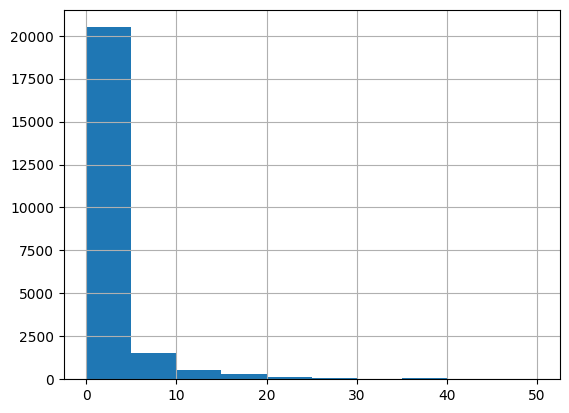

In [ ]:
# | eval: false
etf_executions_features._500us_num_trades.hist()

In [ ]:
# | eval: false
val_counts = etf_executions_features.value_counts(subset="_500us_num_trades")
val_counts.where(val_counts > 100).dropna().index.values.tolist()

/tmp/ipykernel_2559457/800417815.py:1: FutureWarning: In a future version, passing a SparseArray to pd.Index will store that array directly instead of converting to a dense numpy ndarray. To retain the old behavior, use pd.Index(arr.to_numpy()) instead
  val_counts = etf_executions_features.value_counts(subset="_500us_num_trades")


[0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
# | eval: false
ENOUGH_DATA = 7
etf_executions_features.query(f"_500us_num_trades <= {ENOUGH_DATA}")

CLOSE_PRICE = ( etf_executions_features.query("direction == 1").iloc[-1].price + etf_executions_features.query("direction == -1").iloc[-1].price ) / 2
print(CLOSE_PRICE)

60.37


In [ ]:
# | eval: false
etf_executions_features_no_auc = etf_executions_features[etf_executions_features.event.isin([4,5])]
etf_executions_features_no_auc = etf_executions_features_no_auc.query(f"_500us_num_trades <= {ENOUGH_DATA}").assign(pnl_to_close = lambda df_: ( CLOSE_PRICE - df_.price ) / df_.price * 1e4 * df_.direction)


In [ ]:
# | eval: false
etf_executions_features_no_auc = etf_executions_features_no_auc.assign(hit_ratio = lambda df_: ((df_.pnl_to_close) > 0 ))
summary_statistics = etf_executions_features_no_auc.groupby(by="_500us_num_trades").agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_raio=("hit_ratio","mean"))

/tmp/ipykernel_2559457/2295202992.py:2: FutureWarning: In a future version, passing a SparseArray to pd.Index will store that array directly instead of converting to a dense numpy ndarray. To retain the old behavior, use pd.Index(arr.to_numpy()) instead
  summary_statistics = etf_executions_features_no_auc.groupby(by="_500us_num_trades").agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_raio=("hit_ratio","mean"))


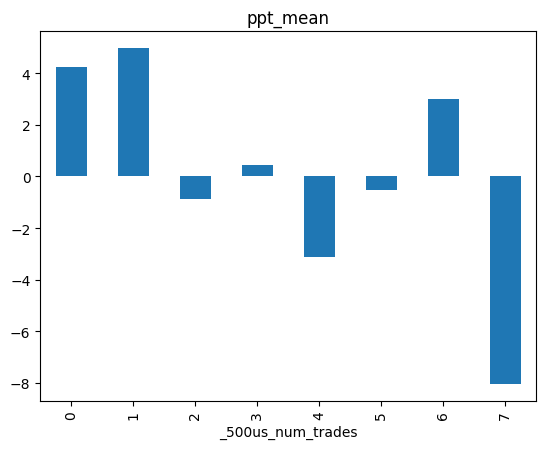

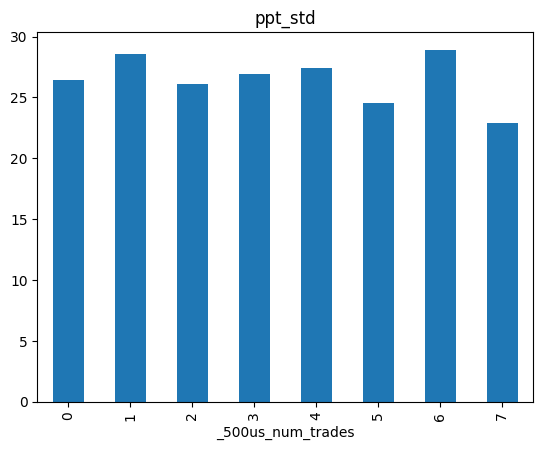

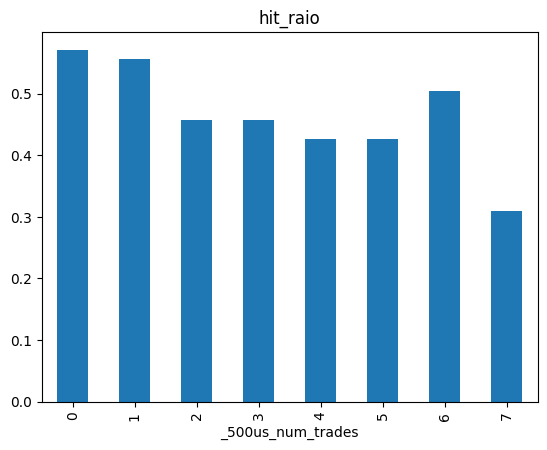

In [ ]:
# | eval: false
import matplotlib.pyplot as plt
for col in summary_statistics:
    summary_statistics[col].plot(title=col, kind="bar")
    plt.show()

### Multi-day

In [ ]:
# | eval: false
df = etf_executions_features_no_auc

In [ ]:
# | eval: false
closing_prices = df.resample('D').transform('last').price

In [ ]:
# | eval: false
df["closing_price"] = closing_prices

In [ ]:
# | eval: false
df.eval("pnl_to_close = (closing_price - price) * 1e4 * direction", inplace=True)
df.eval("hit_ratio = (pnl_to_close > 0)", inplace=True)

In [ ]:
# | eval: false
summary_statistics = df.groupby(by="_500us_num_trades").agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean"))

/tmp/ipykernel_2559457/3805906952.py:1: FutureWarning: In a future version, passing a SparseArray to pd.Index will store that array directly instead of converting to a dense numpy ndarray. To retain the old behavior, use pd.Index(arr.to_numpy()) instead
  summary_statistics = df.groupby(by="_500us_num_trades").agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean"))


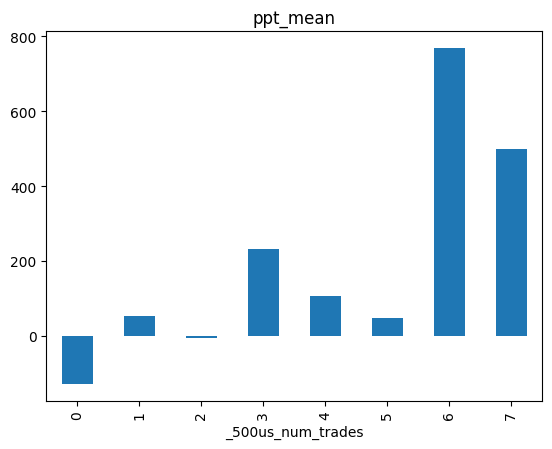

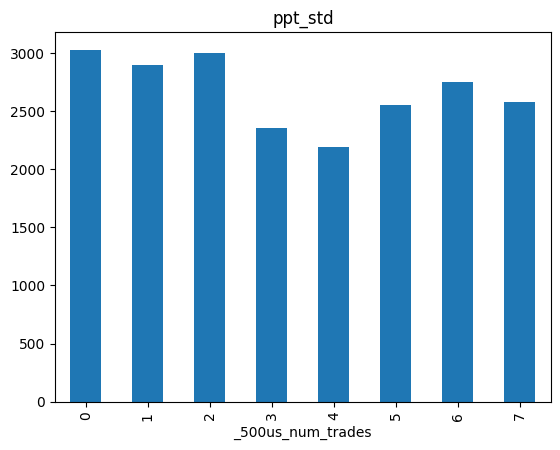

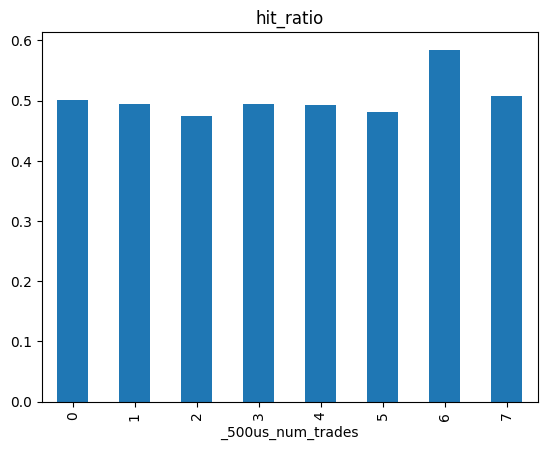

In [ ]:
# | eval: false
import matplotlib.pyplot as plt
for col in summary_statistics:
    summary_statistics[col].plot(title=col, kind="bar")
    plt.show()

In [ ]:
# | eval: false
%store etf_executions_neighbors
%store etf_executions_features

In [ ]:
# etf_executions_features = marginalise(etf_executions_features, over='same_sign/opposite_sign')

In [ ]:
# etf_executions_features.columns

In [ ]:
# etf_executions_features["_500us_num_trades"] = etf_executions_features._500us_num_trades_os_af + etf_executions_features._500us_num_trades_os_bf + etf_executions_features._500us_num_trades_ss_af + etf_executions_features._500us_num_trades_ss_bf

In [ ]:
# etf_execution_features.filter(regex="^_").hist()

In [ ]:
# easy way without query builder
# date_range = [datetime.date(year=2020, month=1, day=2), datetime.date(year=2020, month=1, day=3)]
# df = library.read(ticker, date_range=date_range).data

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()